### Whole-brain model 

In [1]:
import sys
import os

sys.path.insert(1, os.path.expanduser("~/projects/phase_amplitude_encoding"))

In [2]:

import jax
import matplotlib.pyplot as plt
import numpy as np
import scipy
import xarray as xr
from frites.core import copnorm_nd
from hoi.core import get_mi
from mne.time_frequency import psd_array_multitaper
from mne.time_frequency.tfr import tfr_array_morlet, tfr_array_multitaper
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

from src.models import simulate, simulate_delayed

/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
jax.config.update("jax_platform_name", "cpu")

#### Load anatomical data

In [4]:
area_names = [
    "V1",
    "V2",
    "V4",
    "DP",
    "MT",
    "8m",
    "5",
    "8l",
    "TEO",
    "2",
    "F1",
    "STPc",
    "7A",
    "46d",
    "10",
    "9/46v",
    "9/46d",
    "F5",
    "TEpd",
    "PBr",
    "7m",
    "7B",
    "F2",
    "STPi",
    "PROm",
    "F7",
    "8B",
    "STPr",
    "24c",
]

In [5]:
data = np.load("../interareal/markov2014.npy", allow_pickle=True).item()

# Graph parameters
Nareas = 29  # Number of areas
# FLN matrix
flnMat = data["FLN"]
# Distance matrix
D = data["Distances"] * 1e-3 / 3.5
# Hierarchy values
h = np.squeeze(data["Hierarchy"].T)

eta = 0

#### Simulation parameters

In [6]:
ntrials = 300
dt = 1e-4
fsamp = 1 / dt
time = np.arange(-4, 2, 1 / fsamp)
beta = 1e-4
Npoints = len(time)
decim = 20
f = 10  # np.linspace(20, 60, Nareas)[::-1]  # Node natural frequency in Hz
D = (D / dt).astype(int)
flnMat = (1 + eta * h)[:, np.newaxis] * flnMat

seeds = np.random.randint(0, 10000, ntrials)

In [7]:
s = 8 / (2 * np.pi * f)

time_start = 0
time_end = 0.5
timestim = time[(time > time_start) & (time < time_end)] - (time_end - time_start) / 2
ind = np.where((time > time_start) & (time < time_end))[0]
gaussian = np.exp(-(timestim**2) / (2 * s**2))
coupling = np.zeros_like(time)
coupling = (time > time_start) & (time < time_end)

# Coupling strength array (linearly spaced from 1 to 100)
CS = np.linspace(0, 1e-2, ntrials)
seeds = np.random.randint(0, 100000, ntrials)

In [8]:
coupling = CS[:, None] * coupling

In [9]:
Iext = np.zeros((ntrials, Nareas, len(time)))
Iext[:, 0] = coupling

In [10]:
out = []
for trial in tqdm(range(ntrials)):

    out += [
        simulate(
            flnMat,
            1,#oupling[trial],
            f,
            -5,
            fsamp,
            1e-4,
            Npoints,
            Iext[trial],
            seeds[trial],
            decim=decim,
            stim_mode="both",
        )
    ]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:15<00:00,  4.00it/s]


#### Convert to xarray

In [11]:
data = xr.DataArray(
    np.stack(out),
    dims=("trials", "roi", "times"),
    coords=(range(ntrials), area_names, time[::decim]),
).sel(times=slice(-2, 2))

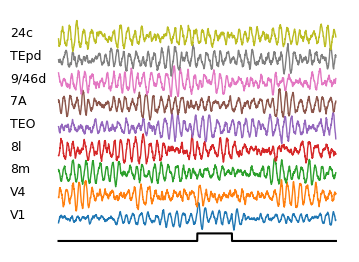

In [12]:
plt.figure(figsize=(10 / 2.54, 8 / 2.54))
ax = plt.subplot(111)
z_data = (data - data.mean("times")) / data.std("times")
for i, roi in enumerate(["V1", "V4", "8m", "8l", "TEO", "7A", "9/46d", "TEpd", "24c"]):
    plt.plot(z_data[-1].times, z_data[-1].values[i].real + (i * 3), lw=1)
    plt.text(-2.7, i * 3, roi, fontsize=9)
mask = (time >= -2) * (time <= 2)
plt.plot(time[mask], (Iext[-1, 0, mask] * 100 - 3) , "k")
plt.axis("off");

plt.savefig("figures/wbm_time_series.png", bbox_inches="tight")

In [13]:
labels = np.tile(np.expand_dims(CS, 1), data.sizes["times"])

In [14]:
mi_fcn = get_mi("gc")
mi_fcn_time = jax.vmap(mi_fcn, in_axes=(2, 2, None, None))

In [15]:
I_S_R1 = []
I_S_R2 = []
I_S_R1_R2 = []
for i in tqdm(range(1, Nareas)):

    z = data.isel(roi=0) * np.conj(data.isel(roi=i))
    A = np.abs(z).values
    dphi = np.unwrap( np.angle(z) )
    mv = np.stack((A, dphi), axis=0)
    
    I_S_R1 += [mi_fcn_time(A[None], labels[None], False, True)]
    I_S_R2 += [mi_fcn_time(dphi[None], labels[None], False, True)]
    I_S_R1_R2 += [mi_fcn_time(mv, labels[None], False, True)]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:11<00:00,  2.51it/s]


In [16]:
I_S_R1 = np.stack(I_S_R1)
I_S_R2 = np.stack(I_S_R2)
I_S_R1_R2 = np.stack(I_S_R1_R2)

In [17]:
kernel = np.hanning(20)
kernel = kernel / kernel.sum()
kernel = kernel[None]

I_S_R1 = scipy.signal.fftconvolve(I_S_R1, kernel , mode="same", axes=1)
I_S_R2 = scipy.signal.fftconvolve(I_S_R2, kernel, mode="same", axes=1)
I_S_R1_R2 = scipy.signal.fftconvolve(I_S_R1_R2, kernel, mode="same", axes=1)

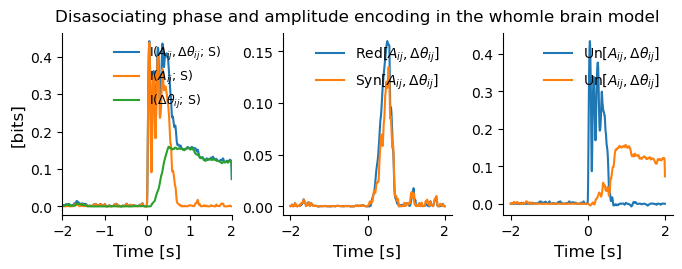

In [18]:
fig = plt.figure(figsize=(20 / 2.54, 6 / 2.54))

ax = plt.subplot(1, 3, 1)

plt.plot(z_data[-1].times, I_S_R1_R2[-1])
plt.plot(z_data[-1].times, I_S_R1[-1])
plt.plot(z_data[-1].times, I_S_R2[-1])

plt.legend(
    [
        r"I($A_{ij}, \Delta\theta_{ij}$; S)",
        r"I($A_{ij}$; S)",
        r"I($\Delta\theta_{ij}$; S)",
    ],
    frameon=False,
    fontsize=9
)

plt.ylabel("[bits]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)
plt.xlim(-2, 2)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]

ax = plt.subplot(1, 3, 2)

red = np.minimum(I_S_R2[-1], I_S_R1[-1])
syn = I_S_R1_R2[-1] - np.maximum(I_S_R2[-1], I_S_R1[-1])

plt.plot(data.times, red)
plt.plot(data.times, syn)

plt.legend(
    [
        r"Red[$A_{ij}, \Delta\theta_{ij}$]",
        r"Syn[$A_{ij}, \Delta\theta_{ij}$]",
    ],
    frameon=False,
)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.xlabel("Time [s]", fontsize=12)

ax = plt.subplot(1, 3, 3)

syn = I_S_R1_R2[-1] - np.maximum(I_S_R2[-1], I_S_R1[-1])

plt.plot(data.times, I_S_R1[-1] - syn)
plt.plot(data.times, I_S_R2[-1] - syn)

plt.legend(
    [
        r"Un[$A_{ij}, \Delta\theta_{ij}$]",
        r"Un[$A_{ij}, \Delta\theta_{ij}$]",
    ],
    frameon=False,
)
plt.xlabel("Time [s]", fontsize=12)

[ax.spines[key].set_visible(False) for key in ["top", "right"]]

plt.subplots_adjust(wspace=.3)
plt.suptitle("Disasociating phase and amplitude encoding in the whomle brain model")

plt.savefig("figures/disasociating.png", bbox_inches="tight")

#### High-oder phase-interactions

In [19]:
from hoi.metrics import SynergyMMI, RedundancyMMI

In [20]:
edges = []

x_s, x_t = np.triu_indices(Nareas, k=1)

roi_st = [f"{area_names[s]}-{area_names[t]}" for s, t in zip(x_s, x_t) ]

In [21]:
for s, t in zip(x_s, x_t):
        phi = np.unwrap( np.angle( data[:, 0] * np.conj(data[:, t]) ) )
        edges += [phi]

In [22]:
edges = np.stack(edges, 1)

In [23]:
edges = xr.DataArray(edges,
                     dims=data.dims,
                     coords=(data.trials, roi_st, data.times))

In [24]:
model_red = RedundancyMMI(edges,
                          CS.astype(np.float_))

model_syn = SynergyMMI(edges,
                          CS.astype(np.float_))

In [25]:
red = model_red.fit(minsize=2, maxsize=2)

syn = model_syn.fit(minsize=2, maxsize=2)

    Copnorm and demean the data
Get list of multiplets
  0%|                                                                                                                  |  0/1 [00:00<?,       ?it/s]/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float64 to dtype=float32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
    Copnorm and demean the data                                                                                                                     
Get list of multiplets
  0%|                                                                                                                  |  0/1 [00:00<?,       ?it/s]/opt/anaconda3/envs/test_env/lib/python3.10/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast va

In [28]:
red.shape

(82215, 2000)

Text(0.5, 0, 'Time [s]')

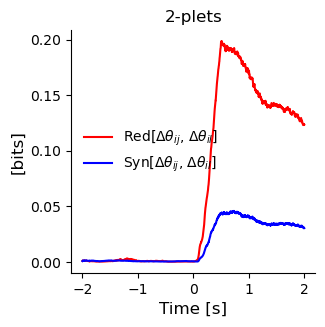

In [34]:
plt.figure(figsize=(8 / 2.54, 8 / 2.54))
ax = plt.subplot(111)
plt.plot(data.times, red.mean(0), "r", label=r"Red[$\Delta\theta_{ij}$, $\Delta\theta_{il}$]")
plt.plot(data.times, np.nanmean(syn, 0), "b", label=r"Syn[$\Delta\theta_{ij}$, $\Delta\theta_{il}$]")
plt.legend(frameon=False)
[ax.spines[key].set_visible(False) for key in ["top", "right"]]
plt.title("2-plets", fontsize=12)
plt.ylabel("[bits]", fontsize=12)
plt.xlabel("Time [s]", fontsize=12)